In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import sympy as sp

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [13]:
m1, m2, m3 = 3.72, 8.0, 68.28
l1, l2 = 0.443, 0.441
a1, a2, a3 = 0.221, 0.221, 0.447
I1, I2, I3 = 0.0608, 0.1297, 5.179
g = 9.81

B1 = m1*a1**2 + I1 + m2*l1**2 + m3*l1**2
B2 = m2*a2**2 + I2 + m3*l2**2
B3 = m2*a2*l1 + m3*l1*l2
B4 = m3*a3**2 + I3
B5 = m3*a3*l1
B6 = m3*a3*l2

D1 = -m1*g*a1 - m2*g*l1 - m3*g*l1
D2 = m2*g*a2 + m3*g*l2
D3 = m3*g*a3
D5 = -m2*a2*l1 + m3*l1*l2

In [14]:
def M(q1, q2, q3):
  M11 = B1 + B2 + 2*B3*np.cos(q2) + B4 + 2*B5*np.cos(-q2 + q3) + 2*B6*np.cos(q3)
  M12 = B2 + B3*np.cos(q2) + B4 + B5*np.cos(-q2 + q3) + 2*B6*np.cos(q3)
  M13 = -B4 - B5*np.cos(-q2 + q3) - B6*np.cos(q3)
  
  M21 = M12
  M22 = B2 + B4 + 2*B6*np.cos(q3)
  M23 = -B4 - B6*np.cos(q3)

  M31 = M13
  M32 = M23
  M33 = B4

  M = np.array([[M11, M12, M13],
                [M21, M22, M23],
                [M31, M32, M33]])

  return M

def G(q1, q2, q3):
  G1 = -D1*np.cos(q1) + D2*np.cos(q1 + q2) + D3*np.cos(q1 + q2 - q3)
  G2 = D2*np.cos(q1 + q2) + D3*np.cos(q1 + q2 - q3)
  G3 = D3*np.cos(q1 + q2 - q3)

  return np.array([G1, G2, G3]).reshape(3, 1)

def C(q1, q2, q3, q1_dot, q2_dot, q3_dot):
  C11 = 2*B3*(-np.sin(q2)*q2_dot) + 2*B6*(-np.sin(q3)*q3_dot)
  C12 = B3*(-np.sin(q2)*q2_dot) - B5*(2*q1_dot + q2_dot - q3_dot) * (-np.sin(-q2 + q3)) + 2*B6*(-np.sin(q3)*q3_dot)
  C13 = B5*(2*q1_dot + q2_dot - q3_dot) * (-np.sin(-q2 + q3)) - B6*(-np.sin(q3)*q3_dot)

  C21 = B3*(-np.sin(q1)*q1_dot) + B5*(-np.sin(-q2 + q3) * (-q2_dot + q3_dot)) + 2*B6*(-np.sin(q3)*q3_dot) - D5*np.sin(q2) * (q1_dot + q2_dot) + B5*(q1_dot + q2_dot - q3_dot) * np.sin(-q2 + q3)
  C22 = 2*B6*(-np.sin(q3)*q3_dot)
  C23 = -B6*(-np.sin(q3)*q3_dot)

  C31 = B5*np.sin(-q2 + q3) * (-q2_dot + q3_dot) + B5 * np.sin(-q2 + q3) * (q1_dot + q2_dot - q3_dot) + B6*np.sin(q3) * (q1_dot + q2_dot - q3_dot)
  C32 = B6*np.sin(q3) * (q1_dot + q2_dot - q3_dot)
  C33 = B6*np.sin(q3) * (q1_dot + q2_dot)

  return np.array([[C11, C12, C13],
                   [C21, C22, C23],
                   [C31, C32, C33]])

In [15]:
# Load polynomial coefficients from JSON file
# Expected structure: approximation_coefficients.right.phi_1, phi_3 (and left)
# Polynomial form: phi(q2) = a*q2³ + b*q2² + c*q2 + d

def load_polynomials_from_json(json_path, side='right', calculated_angles_path=None):
  """
  Load polynomial coefficients, q2, q2_dot, and data count from JSON file.
  
  Args:
    json_path: Path to JSON file with approximation coefficients
    side: 'right' or 'left'
    calculated_angles_path: Optional path to calculated_angles.json file to load q2 data.
                           If None, tries to find it automatically based on measurement name.
    
  Returns:
    Dictionary with:
      - 'phi_1': [a, b, c, d] coefficients for phi_1
      - 'phi_3': [a, b, c, d] coefficients for phi_3
      - 'q2': numpy array of q2 values
      - 'q2_dot': numpy array of q2_dot values (dq2/dt)
      - 'num_data': number of data points
      - 'time': numpy array of time values
      - 'frequency': sampling frequency
  """
  with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  
  coeffs = data['approximation_coefficients'][side]
  
  # Load q2_dot from derivatives
  q2_dot = np.array(data['derivatives'][side]['dq2_dt'])
  
  # Load time array
  time = np.array(data['time'])
  
  # Get number of data points
  num_data = data['metadata'].get('num_frames', len(time))
  frequency = data['metadata'].get('frequency', 100.0)
  
  # Load q2: first try from approximation_data.json, then from calculated_angles.json
  q2 = None
  if 'q2' in data and side in data['q2']:
    # q2 is directly available in approximation_data.json
    q2 = np.array(data['q2'][side])
  elif 'frame_range' in data['metadata']:
    # Fallback: load from calculated_angles.json if frame_range is available
    frame_range = data['metadata']['frame_range']
    
    # Try to find calculated_angles.json file
    if calculated_angles_path is None:
      # Try to construct path automatically
      measurement_name = data['metadata'].get('measurement', 'Measurement1')
      base_dir = os.path.dirname(json_path) or '.'
      calculated_angles_path = os.path.join(base_dir, 'data', 'calculated_angles', 
                                           f'{measurement_name}_calculated_angles.json')
      # If not found, try in parent directory
      if not os.path.exists(calculated_angles_path):
        calculated_angles_path = os.path.join(os.path.dirname(base_dir), 'data', 'calculated_angles',
                                             f'{measurement_name}_calculated_angles.json')
    
    if calculated_angles_path and os.path.exists(calculated_angles_path):
      with open(calculated_angles_path, 'r', encoding='utf-8') as f:
        angles_data = json.load(f)
      
      start_frame = frame_range.get('start_frame', 0)
      end_frame = frame_range.get('end_frame', None)
      
      # Load q2 based on side
      if side == 'right':
        q2_array = np.array(angles_data['angles']['right']['qr2'])
      else:
        q2_array = np.array(angles_data['angles']['left']['ql2'])
      
      # Apply frame range
      if end_frame is not None:
        q2 = q2_array[start_frame:end_frame]
      else:
        q2 = q2_array[start_frame:]
    else:
      print(f"⚠️  Warning: Could not find calculated_angles.json file at {calculated_angles_path}")
      print(f"   q2 will be None. Please provide calculated_angles_path parameter.")
  else:
    print(f"⚠️  Warning: q2 data not found in approximation_data.json and no frame_range available.")
  
  result = {
    'phi_1': [coeffs['phi_1']['a'], coeffs['phi_1']['b'], coeffs['phi_1']['c'], coeffs['phi_1']['d']],
    'phi_3': [coeffs['phi_3']['a'], coeffs['phi_3']['b'], coeffs['phi_3']['c'], coeffs['phi_3']['d']],
    'q2': q2,
    'q2_dot': q2_dot,
    'num_data': num_data,
    'time': time,
    'frequency': frequency
  }
  
  return result

In [16]:
def phi(q2, coeffs):
  a, b, c, d = coeffs
  return a * q2**3 + b * q2**2 + c * q2 + d


def phi_dot(q2, coeffs):
  a, b, c, d = coeffs
  return 3*a * q2**2 + 2*b * q2 + c

def phi_dot_dot(q2, coeffs):
  a, b, c, d = coeffs
  return 6*a * q2 + 2*b

def vector_phi_dot(phi_1_dot, phi_3_dot):
  return np.array([phi_1_dot, 1, phi_3_dot]).transpose()

def vector_phi_dot_dot(phi_1_dot_dot, phi_3_dot_dot):
  return np.array([phi_1_dot_dot, 0, phi_3_dot_dot]).transpose()

In [17]:
def alpha(M, vector_phi_dot):
  return np.array([1, 0, 0]) @ M @ vector_phi_dot

def beta(M, C, vector_phi_dot, vector_phi_dot_dot):
  return np.array([1, 0, 0]) @ (M @ vector_phi_dot_dot + C @ vector_phi_dot)

def gamma(G):
  return np.array([1, 0, 0]) @ G

In [18]:
# Example usage: Load polynomials and data
json_path = 'approximation_data.json'  # Path to approximation JSON file
calculated_angles_path = 'data/calculated_angles/Measurement1_calculated_angles.json'  # Optional: path to calculated angles

# Load data
data = load_polynomials_from_json(json_path, side='right', calculated_angles_path=calculated_angles_path)

# Extract coefficients
coeffs_1 = data['phi_1']  # [a, b, c, d] for phi_1
coeffs_3 = data['phi_3']  # [a, b, c, d] for phi_3

# Extract data arrays
q2_data = data['q2']  # numpy array of q2 values (in radians)
q2_dot_data = data['q2_dot']  # numpy array of q2_dot values (dq2/dt, in radians/s)
time_data = data['time']  # numpy array of time values
num_data = data['num_data']  # number of data points
frequency = data['frequency']  # sampling frequency
dt = 1 / frequency

In [19]:
# def M(q1, q2, q3):
#     q0, q1_, q2_ = q1, q2, q3

#     c1  = np.cos(q1_)
#     c2  = np.cos(q2_)
#     c12 = np.cos(q2_ - q1_)

#     M00 = (
#         m1 * a1**2 + I1
#         + m2 * (l1**2 + a2**2 + 2*l1*a2*c1) + I2
#         + m3 * (l1**2 + l2**2 + a3**2
#                 + 2*l1*l2*c1 + 2*l1*a3*c12 + 2*l2*a3*c2) + I3
#     )

#     M01 = (
#         m2 * (a2**2 + l1*a2*c1) + I2
#         + m3 * (l2**2 + a3**2
#                 + l1*l2*c1 + l1*a3*c12 + 2*l2*a3*c2) + I3
#     )

#     M02 = -m3 * (a3**2 + l1*a3*c12 + l2*a3*c2) - I3

#     M11 = (
#         m2 * a2**2 + I2
#         + m3 * (l2**2 + a3**2 + 2*l2*a3*c2) + I3
#     )

#     M12 = -m3 * (a3**2 + l2*a3*c2) - I3

#     M22 = m3 * a3**2 + I3

#     return np.array([
#         [M00, M01, M02],
#         [M01, M11, M12],
#         [M02, M12, M22]
#     ])

# def G(q1, q2, q3):
#     q0, q1_, q2_ = q1, q2, q3

#     G0 = g * (
#         m1 * a1 * np.cos(q0)
#         + m2 * (l1 * np.cos(q0) + a2 * np.cos(q0 + q1_))
#         + m3 * (l1 * np.cos(q0)
#                 + l2 * np.cos(q0 + q1_)
#                 + a3 * np.cos(q0 + q1_ - q2_))
#     )

#     G1 = g * (
#         m2 * a2 * np.cos(q0 + q1_)
#         + m3 * (l2 * np.cos(q0 + q1_)
#                 + a3 * np.cos(q0 + q1_ - q2_))
#     )

#     G2 = -m3 * g * a3 * np.cos(q0 + q1_ - q2_)

#     return np.array([G0, G1, G2]).reshape(-1,1)

# def C(q1, q2, q3, q1_dot, q2_dot, q3_dot):
#     q0, q1_, q2_ = q1, q2, q3
#     q0d, q1d, q2d = q1_dot, q2_dot, q3_dot

#     s1  = np.sin(q1_)
#     s2  = np.sin(q2_)
#     s12 = np.sin(q2_ - q1_)

#     # Частные производные элементов M
#     dM00_dq1 = -2*m2*l1*a2*s1 + m3*(-2*l1*l2*s1 + 2*l1*a3*s12)
#     dM00_dq2 = m3*(-2*l1*a3*s12 - 2*l2*a3*s2)

#     dM01_dq1 = -m2*l1*a2*s1 + m3*(-l1*l2*s1 + l1*a3*s12)
#     dM01_dq2 = m3*(-l1*a3*s12 - 2*l2*a3*s2)

#     dM02_dq1 = -m3*l1*a3*s12
#     dM02_dq2 = m3*(l1*a3*s12 + l2*a3*s2)

#     dM11_dq2 = -2*m3*l2*a3*s2
#     dM12_dq2 = m3*l2*a3*s2

#     C00 = 0.5 * (dM00_dq1*q1d + dM00_dq2*q2d)

#     C01 = 0.5 * (
#         dM00_dq1*q0d
#         + 2*dM01_dq1*q1d
#         + (dM01_dq2 + dM02_dq1)*q2d
#     )

#     C02 = 0.5 * (
#         dM00_dq2*q0d
#         + (dM02_dq1 + dM01_dq2)*q1d
#         + 2*dM02_dq2*q2d
#     )

#     C10 = -0.5 * (
#         dM00_dq1*q0d
#         + (dM01_dq2 - dM02_dq1)*q2d
#     )

#     C11 = 0.5 * dM11_dq2*q2d

#     C12 = 0.5 * (
#         (dM01_dq2 - dM02_dq1)*q0d
#         + dM11_dq2*q1d
#         + 2*dM12_dq2*q2d
#     )

#     C20 = -0.5 * (
#         dM00_dq2*q0d
#         + (dM02_dq1 - dM01_dq2)*q1d
#     )

#     C21 = 0.5 * (
#         (-dM02_dq1 - dM01_dq2)*q0d
#         - dM11_dq2*q1d
#     )

#     return np.array([
#         [C00, C01, C02],
#         [C10, C11, C12],
#         [C20, C21, 0.0]
#     ])


In [20]:
theta = 0
theta_d = 0
frequency = 1000
dt = 1 / frequency
t = 0

theta_list = []
theta_d_list = []
theta_dd_list = []
time_list = []

for i in range(frequency):
  q1 = phi(theta, coeffs_1)
  q3 = phi(theta, coeffs_3)
  q1_dot = phi_dot(theta, coeffs_1)
  q3_dot = phi_dot(theta, coeffs_3)

  M_val = M(q1, theta, q3)
  C_val = C(q1, theta, q3, vector_phi_dot(q1_dot, q3_dot)[0], theta_d, vector_phi_dot(q1_dot, q3_dot)[2])
  G_val = G(q1, theta, q3)

  alpha_val = alpha(M_val, vector_phi_dot(q1_dot, q3_dot))
  beta_val = beta(M_val, C_val, vector_phi_dot(q1_dot, q3_dot), vector_phi_dot_dot(q1_dot, q3_dot))
  gamma_val = gamma(G_val)


  theta_dd = (-beta_val * theta_d**2 - gamma_val) / alpha_val
  theta_d += theta_dd[0] * dt
  theta += theta_d * dt

  theta_list.append(theta)
  theta_d_list.append(theta_d)
  theta_dd_list.append(theta_dd)
  time_list.append(t)

  t += dt

theta_list = np.array(theta_list)
theta_d_list = np.array(theta_d_list)
theta_dd_list = np.array(theta_dd_list)

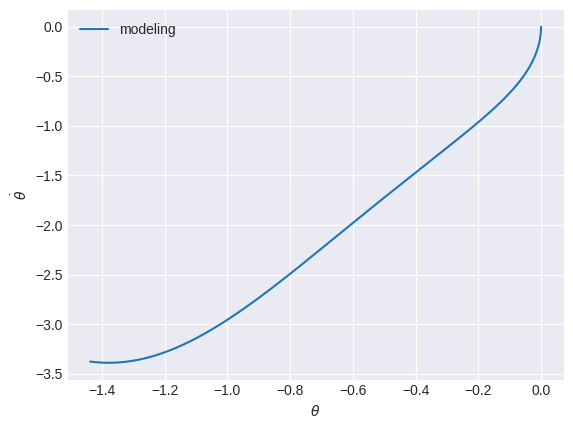

In [21]:
plt.plot(theta_list, theta_d_list, label='modeling')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.legend()
plt.show()

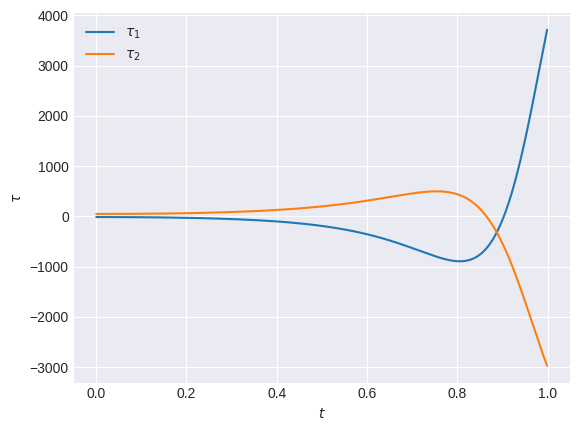

In [22]:
tau_1_list = []
tau_2_list = []

for i in range(frequency):
  q1 = phi(theta_list[i], coeffs_1)
  q3 = phi(theta_list[i], coeffs_3)
  q1_dot = phi_dot(theta_list[i], coeffs_1) * theta_d_list[i]
  q3_dot = phi_dot(theta_list[i], coeffs_3) * theta_d_list[i]
  q1_dot_dot = phi_dot_dot(theta_list[i], coeffs_1) * theta_d_list[i]**2 + phi_dot(theta_list[i], coeffs_1) * theta_dd_list[i]
  q3_dot_dot = phi_dot_dot(theta_list[i], coeffs_3) * theta_d_list[i]**2 + phi_dot(theta_list[i], coeffs_3) * theta_dd_list[i]

  q_d = np.array([
    [q1_dot],
    [theta_d_list[i]],
    [q3_dot]
  ])

  q_dd = np.array([q1_dot_dot, theta_dd_list[i], q3_dot_dot]).reshape(-1, 1)

  M_val = M(q1, theta_list[i], q3)
  C_val = C(q1, theta_list[i], q3, q1_dot, theta_d_list[i], q3_dot)
  G_val = G(q1, theta_list[i], q3)

  # print(M_val.shape, q_dd.shape, C_val.shape, q_d.shape, G_val.shape)

  Bu = M_val @ q_dd + C_val @ q_d + G_val
  
  tau_1_list.append(Bu[1])
  tau_2_list.append(Bu[2])


plt.plot(time_list, tau_1_list, label=r'$\tau_1$')
plt.plot(time_list, tau_2_list, label=r'$\tau_2$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\tau$')
plt.legend()
plt.show()